## 知识点

### 1. 准备数据

* 选取埋点：videoFinished / videoQuitted / problemAnswered
* 清洁
    - 移除缺少eventTime / device字段的埋点
    - 移除problemAnswered中，duration小于1或大于等于2000的埋点
    - 移除video埋点中，duration小于5或大于等于2000的埋点

### 2. 计算视频比值

* VR(U, V) = T(U) / T(V)

In [2]:
from pymongo import MongoClient

conn = MongoClient('10.8.8.111:27017')

mdp = conn['ronfedb']['mdp']

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 1, "correct": True}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


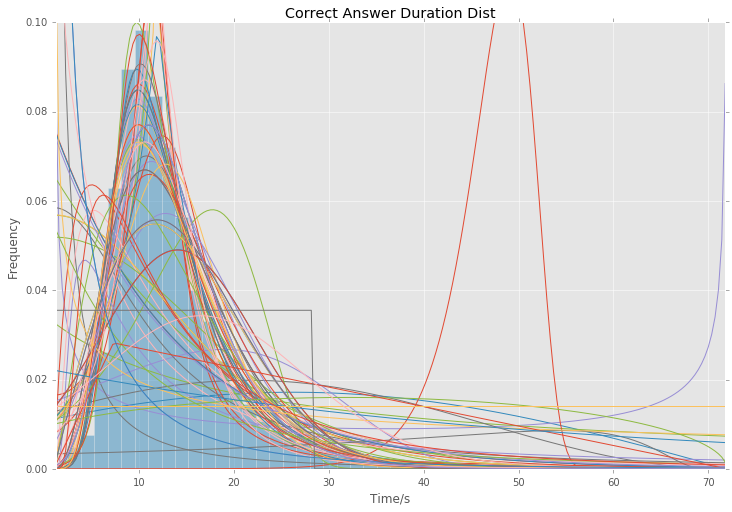

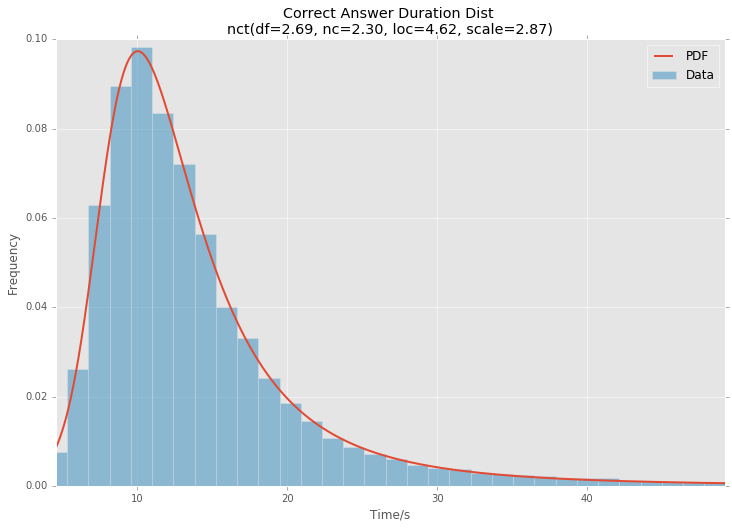

In [4]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# remove extreme values
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Correct Answer Duration Dist')
ax.set_xlabel(u'Time/s')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Correct Answer Duration Dist \n' + dist_str)
ax.set_xlabel(u'Time/s')
ax.set_ylabel('Frequency')

In [6]:
print(best_fir_paramms)
print(param_names)

(2.6887150227976653, 2.2974345305933501, 4.6247265446448083, 2.8686512366660137)
['df', 'nc', 'loc', 'scale']


In [12]:
from scipy.stats import nct
df = best_fir_paramms[0]
nc = best_fir_paramms[1]
loc = best_fir_paramms[2]
scale = best_fir_paramms[3]

xo = np.linspace(nct.ppf(0.01, df, nc, loc, scale), nct.ppf(0.99, df, nc, loc, scale), 100)

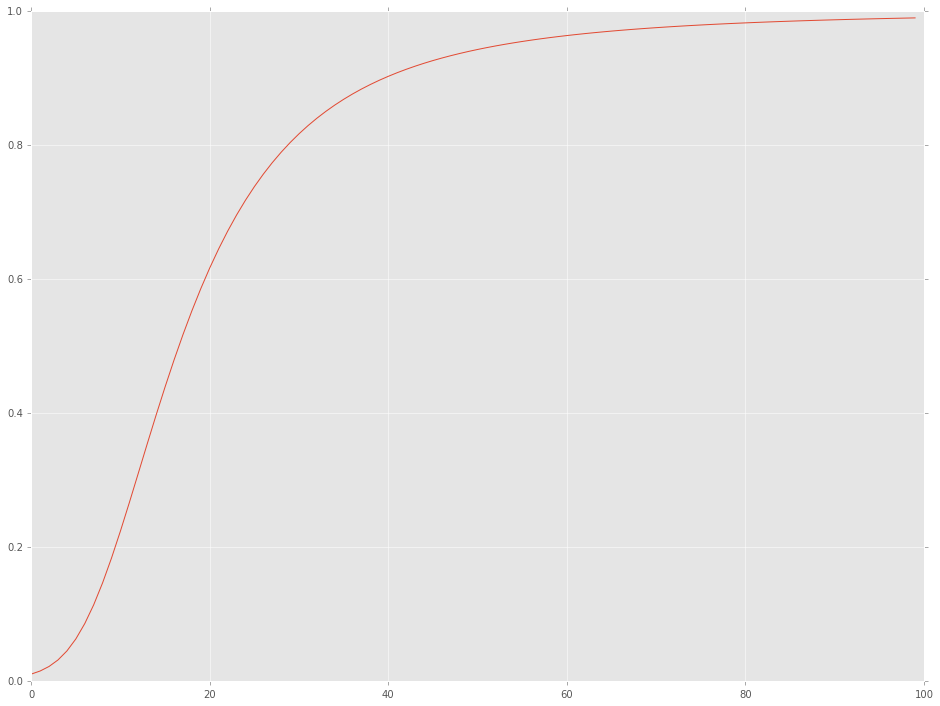

In [14]:
xoo = nct.cdf(xo, df, nc, loc, scale)
plt.plot(xoo)
plt.show()

In [15]:
pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 4, "correct": True}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']

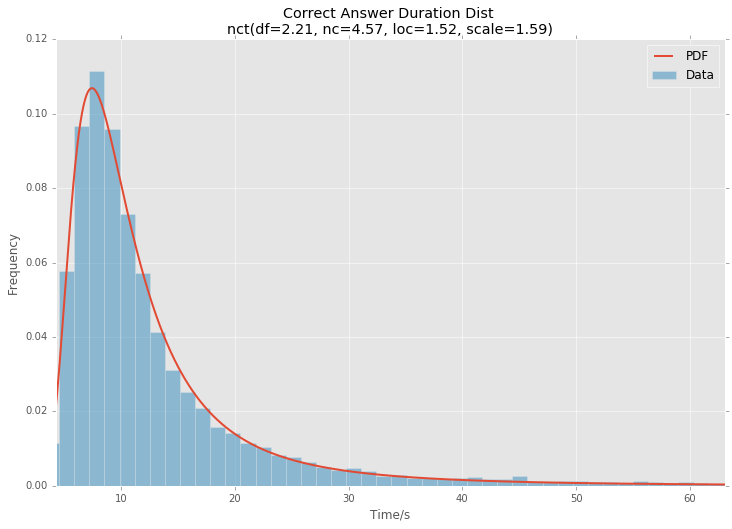

In [17]:
# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

params = nct.fit(data)
pdf = make_pdf(nct, params)
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Correct Answer Duration Dist \n' + dist_str)
ax.set_xlabel(u'Time/s')
ax.set_ylabel('Frequency')

In [1]:
from pymongo import MongoClient

conn = MongoClient('10.8.8.111:27017')

mdp = conn['ronfedb']['mdp']

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 1, "correct": False}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']

In [3]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# remove extreme values
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
#                 try:
#                     if ax:
#                         pd.Series(pdf, x).plot(ax=ax)
#                     end
#                 except Exception:
#                     pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 1, "correct": True}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Plot for comparison
# plt.figure(figsize=(12,8))
# ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
# dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)
# best_dist = getattr(st, best_fit_name)

print("Level 1 Correct")
print(best_fit_name)


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 1, "correct": False}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 1 InCorrect")
print(best_fit_name)

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 2, "correct": True}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 2 Correct")
print(best_fit_name)


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 2, "correct": False}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 2 InCorrect")
print(best_fit_name)

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 3, "correct": True}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 3 Correct")
print(best_fit_name)


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 3, "correct": False}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 3 InCorrect")
print(best_fit_name)



pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 4, "correct": True}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 4 Correct")
print(best_fit_name)


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 4, "correct": False}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 4 InCorrect")
print(best_fit_name)

Level 1 Correct
nct
Level 1 InCorrect
foldcauchy
Level 2 Correct
invgamma
Level 2 InCorrect
mielke
Level 3 Correct
johnsonsu
Level 3 InCorrect
fisk
Level 4 Correct
nct
Level 4 InCorrect
nct


In [2]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
from pymongo import MongoClient

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

mdp = MongoClient("10.8.8.111:27017")['ronfedb']['mdp']

# remove extreme values
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
#                 try:
#                     if ax:
#                         pd.Series(pdf, x).plot(ax=ax)
#                     end
#                 except Exception:
#                     pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 2}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 2")
print(best_fit_name)

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 3}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 3")
print(best_fit_name)


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 4}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']


# Load data from statsmodels datasets
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200)

print("Level 4")
print(best_fit_name)

Level 2
invweibull
Level 3
johnsonsu
Level 4
nct
